<a href="https://colab.research.google.com/github/ojw92/NLP-VOC/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### BERT_Train
#### v. 20230918

In [1]:
import accelerate
import transformers

transformers.__version__, accelerate.__version__

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-09-18 05:56:08.022529: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-18 05:56:08.171385: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


('4.33.0', '0.22.0')

In [2]:
# Check if the GPU can be detected
import tensorflow as tf

device_name = tf.test.gpu_device_name()              # '/device:GPU:0' means GPU is enabled
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2023-09-18 05:56:10.548132: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-18 05:56:10.550461: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-18 05:56:10.550609: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-18 05:56:12.198538: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-18 05:56:12.198656: I tensorflow/compile

In [3]:
import torch
# torch.cuda.is_available = lambda : False

if torch.cuda.is_available():
   dev = "cuda:0"
else:
    dev = "cpu"
device = torch.device(dev)
print(device)

cuda:0


In [4]:
print(tf.config.list_physical_devices('GPU'))
torch.cuda.is_available()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-09-18 05:56:12.220727: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-18 05:56:12.220871: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-18 05:56:12.221019: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


True

In [5]:
# Check running environment info regarding Cuda and devices

import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION', )

from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')

# call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())


__Python VERSION: 3.8.10 (default, May 26 2023, 14:05:08) 
[GCC 9.4.0]
__pyTorch VERSION: 2.0.1+cu117
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
__CUDNN VERSION: 8500
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0


In [6]:
!cat /proc/meminfo            # check memory resources available

MemTotal:       16263492 kB
MemFree:         9369904 kB
MemAvailable:   11774124 kB
Buffers:          185828 kB
Cached:          2497192 kB
SwapCached:            0 kB
Active:           626448 kB
Inactive:        5654876 kB
Active(anon):       3320 kB
Inactive(anon):  3680572 kB
Active(file):     623128 kB
Inactive(file):  1974304 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:       4194304 kB
SwapFree:        4194304 kB
Dirty:               628 kB
Writeback:            48 kB
AnonPages:       3555820 kB
Mapped:          1305880 kB
Shmem:             85500 kB
KReclaimable:     109868 kB
Slab:             225264 kB
SReclaimable:     109868 kB
SUnreclaim:       115396 kB
KernelStack:       19104 kB
PageTables:        34404 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:    12326048 kB
Committed_AS:   10736220 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       43060 kB
VmallocChunk:          0 kB
Percpu:          

In [7]:
# install wandb for tracking data on dashboard
#!pip install datasets wandb evaluate -qU
!wget https://raw.githubusercontent.com/huggingface/transformers/master/examples/pytorch/text-classification/run_glue.py

/usr/bin/sh: 1: wget: not found


In [8]:
import wandb

# log in to have data synced to account
wandb.login()

# log every trained model
%env WANDB_LOG_MODEL=true

wandb: Currently logged in as: ojw92. Use `wandb login --relogin` to force relogin


env: WANDB_LOG_MODEL=true


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# filter training data to desired dates
df = pd.read_csv('train_tab.csv', index_col=0).drop_duplicates()
#df = df[df.columns[0:5]]

# filter training data to desired dates
from datetime import datetime, timedelta

df = df[df.Date.apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S').date() > datetime(2022,2,21).date())]

# For class imbalance, use roughly same ratio of R & N
# df = pd.concat([df[df.Class=='R'], df[df.Class=='N'].iloc[::3, :]]).sample(frac=0.001, random_state=5) # mini random sample

# Reduce data to reduce training time to test features
df = df.sample(frac=0.2, random_state=5)

In [10]:
# Define Title + Content concatenator
from timeit import default_timer as timer
import re

def data_concat(df22, R_known=True):

    # Split the input dataframe into Text (Title + Contents) and Classes dataframes
    # input must have 3 columns of string entries (Title, Contents, and Classes)

    # check if every row entry of each column is string type (some are NaN, so no)
    # print(df22.applymap(lambda x : type(x).__name__).eq({'Title': 'str', 'Content': 'str', 'Class':'str'}))

    # convert NaN to empty strings (NaN -> str)
        # df22.apply(str) converts all columns to str, as well
    df22 = df22.replace(float('nan'), '', regex=True)

    # concatenate strings of title & content with a " " in between (1 body of text)
    df22['Text'] = df22['Title'] + " " + df22['Content']      # slicing DataFrame via .iloc[:,0] makes it a Series
    df22 = df22.loc[: , ['Text', 'Class']]    # so initialize it as a DataFrame. pd.DataFrame(some_Series) works

    if R_known == True:
    # R, r, YR = 1;     N, n, YN = 0
        R_cases = re.compile('R|YR|yy|Y', re.IGNORECASE)      # remove the 'Y' cases later
        N_cases = re.compile('N|YN', re.IGNORECASE)
        df22['Class'] = df22['Class'].replace(to_replace=R_cases, value=1)
        df22['Class'] = df22['Class'].replace(to_replace=N_cases, value=0)
    else:
        # R_known == False; prepping not yet classified data
        Y_N_cases = re.compile('Y|N', re.IGNORECASE)
        df22['Class'] = df22['Class'].replace(to_replace=Y_N_cases, value=0)     # all N's for simplicity

    df22['Class'] = df22['Class'].astype('int32')


    return df22


In [11]:
# combine title & content as text22, clean the text, then combine it with labels to a single df
df = data_concat(df)
df.head()

,Text,Class
13534,Using S22 Ultra as Trackpad for Galaxy Tab S9 ...,0
6448,"Tab S8 with slim keyboard, change language As ...",0
1426,Galaxy Tab + Total Wireless? Hi all! Can anyon...,0
11060,How do you use your Samsung Tablet to aide in ...,0
6506,Bring Back Opacity Option for Calculator App H...,0


In [12]:
df['Class'].value_counts()

Class
0    2459
1     191
Name: count, dtype: int64

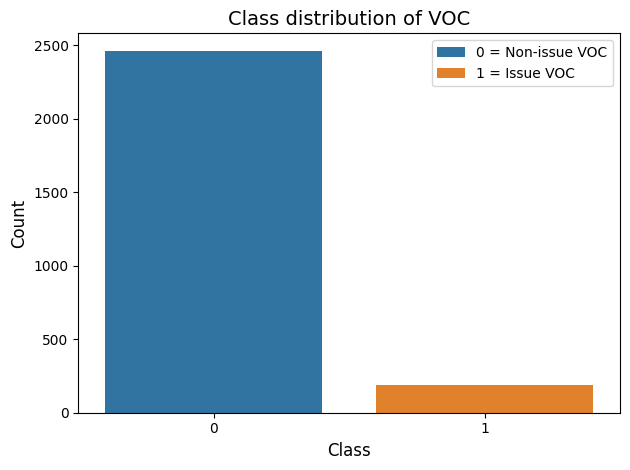

In [13]:
# Data Exploration - Histogram of Classes
sns.countplot(x=df['Class'], hue=df['Class'], dodge=False, data=df['Text'])
plt.title('Class distribution of VOC', fontsize=14)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
"""
from matplotlib.patches import Rectangle
cmap = plt.get_cmap('jet')
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in [cmap(0.27), cmap(0.75)]]
plt.legend(handles, ['0 = Non-issue VOC', '1 = Issue VOC'])
"""
plt.legend(['0 = Non-issue VOC', '1 = Issue VOC'])
plt.tight_layout()
plt.show()

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
          'figure.figsize': (5.75, 5),
         'axes.labelsize': 'medium',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

### Split data into training & validation sets

In [14]:
from sklearn.model_selection import train_test_split

X = df["Text"]          # formerly list(df["Text"]). Monitor for errors
y = df["Class"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1,stratify=y)

In [15]:
len(X_train),len(X_val)

(2385, 265)

In [16]:
# Data Exploration - use of the tf-idf algorithm to discern which words in the corpus play a key role in +/- classification (according to tf-idf)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

#X_train = df['Text']
#y_train = df['Class']
min_df = 15       # consider words that occur at least this many times

# Tf-idf vectorization with bi-grams
print('==========     Tf-idf, 2-gram     ==========')
vect = TfidfVectorizer(min_df=min_df,
        ngram_range = (1,2),      # (min,max) n values for n-grams to be extract & created as features (default=1)
        ).fit(X_train)            # vect.fit(x).transform(x) = vect.fit_transform(x)
print("How many features are there? ", len(vect.get_feature_names_out()))
print("Type of vect: ", type(vect))
print("Vect: ", vect)

X_train_vectorized = vect.transform(X_train)
print("Type of X_train_vectorized: ", type(X_train_vectorized))
print("Shape of X_train_vectorized:", X_train_vectorized.shape)
#print("X_train_vectorized: ", X_train_vectorized)

# Initialize logistic regression model
tf_model = LogisticRegression(max_iter=10000)
tf_model.fit(X_train_vectorized, y_train)

feature_names = np.array(vect.get_feature_names_out())

# Print words with smallest & highest tf-idf scores. Higher score = more important, relevant word
sorted_tfidf_index = X_train_vectorized.max(0).toarray()[0].argsort()
print('\nSmallest tf-idf:\n{}\n'.format(feature_names[sorted_tfidf_index[:10]]))
print('Largest tf-idf: \n{}'.format(feature_names[sorted_tfidf_index[:-11:-1]]))

# Print words with smallest & highest coefficients. Larger coef = contributes more to classifying as 1
sorted_coef_index = tf_model.coef_[0].argsort()
print('\nSmallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

==========     Tf-idf, 2-gram     ==========
How many features are there?  2172
Type of vect:  <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Vect:  TfidfVectorizer(min_df=15, ngram_range=(1, 2))
Type of X_train_vectorized:  <class 'scipy.sparse._csr.csr_matrix'>
Shape of X_train_vectorized: (2385, 2172)

Smallest tf-idf:
['sort of' 'time and' 'that one' 'overall' 'fact' 'except' 'see if'
 'likely' 'of them' 'and they']

Largest tf-idf: 
['size' 'finally' 'data' 'multi' 'input' 'guess' 'news' 'email' 'location'
 'part']

Smallest Coefs:
['s7' 'for' 'tab s7' 'lite' 'one' 'galaxy' 's6 lite' 'be' 'looking'
 'way to']

Largest Coefs: 
['s8' 'tab s8' 'issue' 'this' 'when' 'else' 'bug' 'problem' 'not'
 'battery']


In [17]:
# Define a new function to draw a word map

import gensim
from sklearn.manifold import TSNE
import random

def semantic_similarity(X_train):

    # X_train should be a single-column DataFrame of preprocessed Title + Content (text22 or df22['Text'])
    X_train = X_train.apply(lambda x: gensim.utils.simple_preprocess(str(x)))
    # Train the word2vec model
    w2v_model = gensim.models.Word2Vec(X_train,
                                    vector_size=100,   # size of vectors desired
                                    window=5,  # # of words before & after target word to use as context
                                    min_count=2        # min_df
                                    )
    w2v_model.build_vocab(X_train)  # prepare the model vocabulary
    w2v_model.train(X_train, total_examples=w2v_model.corpus_count, epochs=w2v_model.epochs)
    vocab_size, embedding_size = w2v_model.wv.vectors.shape

    n_samples = 250
    # Sample random words from model dictionary
    random_i = random.sample(range(vocab_size), n_samples)
    # def token2word(token):
    #     return w2v_model.wv.index_to_key[token]
    random_w = [w2v_model.wv.index_to_key[i] for i in random_i]

    # Generate Word2Vec embeddings of each word
    word_vecs = np.array([w2v_model.wv[w] for w in random_w])   # 'Word2Vec' object not subscriptable; use .wv

    # Apply t-SNE to Word2Vec embeddings, reducing to 2 dims
    tsne = TSNE()
    tsne_e = tsne.fit_transform(word_vecs)

    # Plot t-SNE result
    plt.figure(figsize=(32, 32))
    plt.scatter(tsne_e[:, 0], tsne_e[:, 1], marker='o', c=range(len(random_w)), cmap=plt.get_cmap('Spectral'))

    for label, x, y, in zip(random_w, tsne_e[:, 0], tsne_e[:, 1]):
        plt.annotate(label,
                    xy=(x, y), xytext=(0, 15),
                    textcoords='offset points', ha='right', va='bottom',
                    bbox=dict(boxstyle='round, pad=0.2', fc='yellow', alpha=0.1))

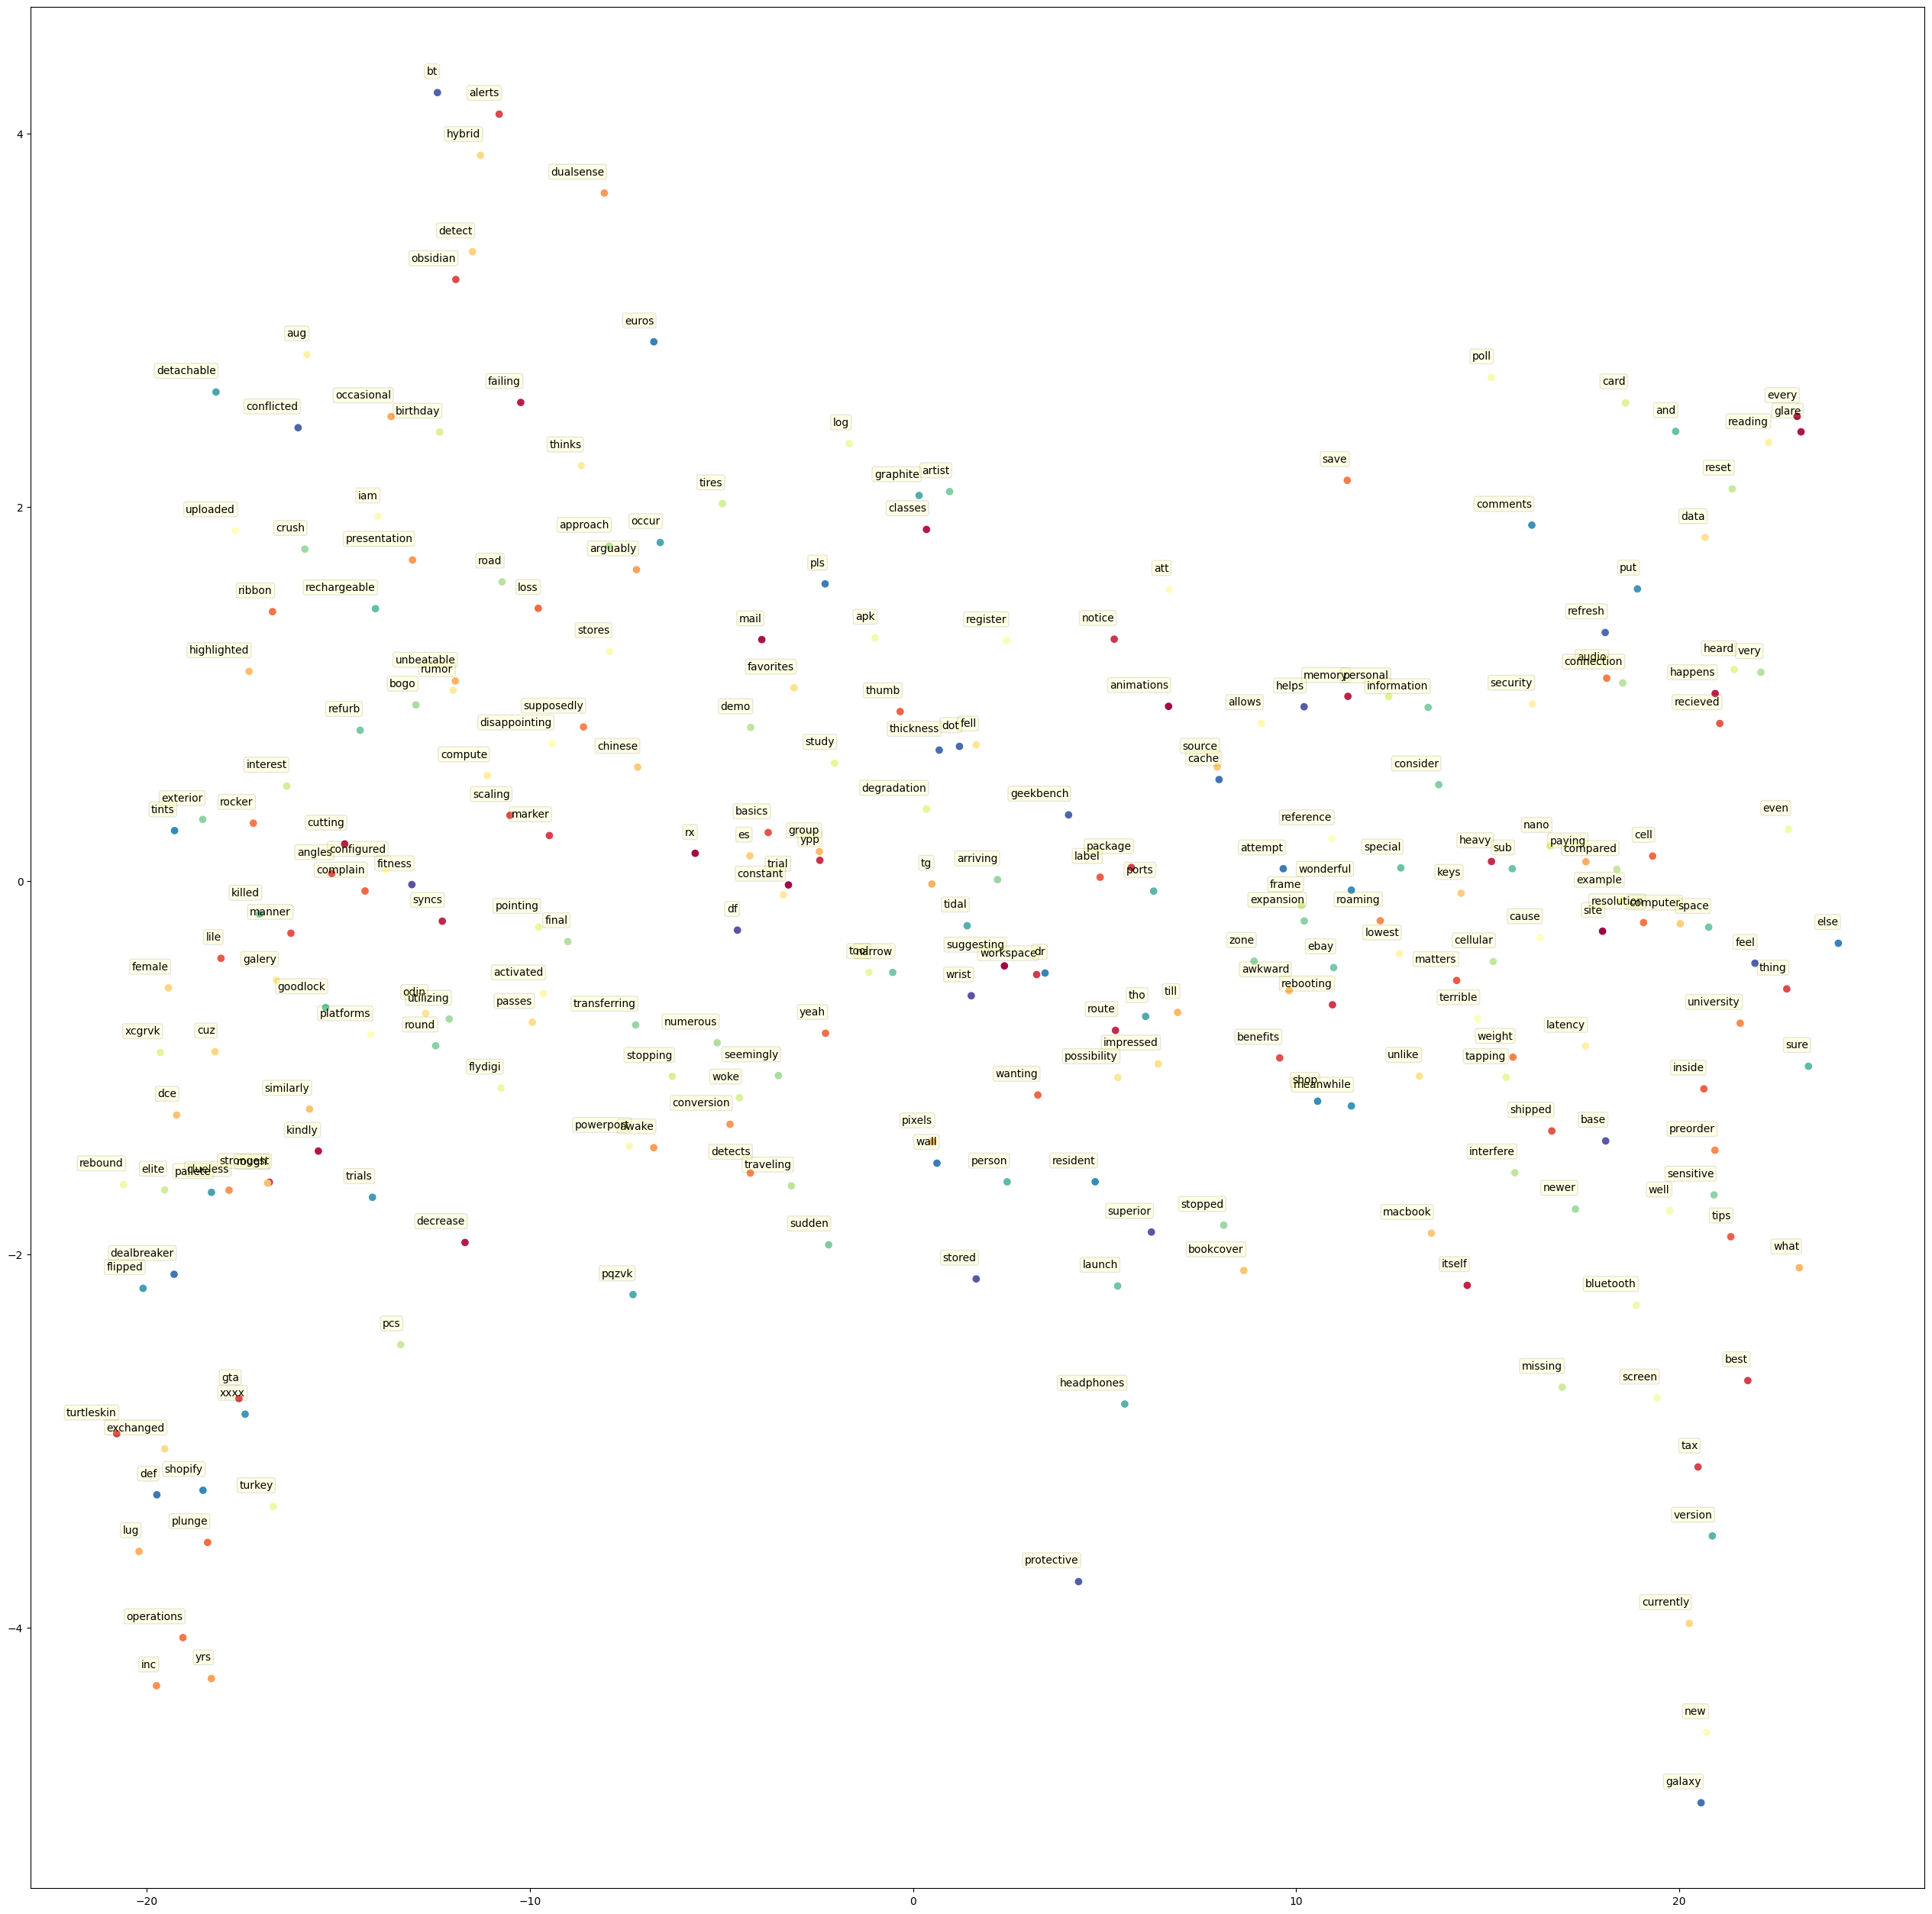

In [18]:
# Train the word2vec model
w2v_model = gensim.models.Word2Vec(X_train,
                                   vector_size=100,   # size of vectors desired
                                   window=5,          # number of words before & after target word to use as context
                                   min_count=15       # min_df
                                   )
w2v_model.build_vocab(X_train)                        # prepare the model vocabulary
w2v_model.train(X_train, total_examples=w2v_model.corpus_count, epochs=w2v_model.epochs)
# w2v_model.wv.index_to_key                           # all words that Word2Vec model learned a vector for (with min_df=2)

# Find the most similar words to "king" based on word vectors from our trained model
# w2v_model.wv.most_similar('king')

# Visualizing Word2Vec Embeddings with t-SNE
semantic_similarity(X_train)


In [19]:
# Create torch dataset
class VOC_Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [20]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [22]:
model = model.to('cuda')          # model.cuda()

In [23]:
sample_data = ["This is possibly the worst battery I have ever seen on a mobile device",
            "How is my device running so smoothly?"]
tokenizer(sample_data, padding=True, truncation=True, max_length=512)

{'input_ids': [[101, 2023, 2003, 4298, 1996, 5409, 6046, 1045, 2031, 2412, 2464, 2006, 1037, 4684, 5080, 102], [101, 2129, 2003, 2026, 5080, 2770, 2061, 15299, 1029, 102, 0, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]]}

In [24]:
X_train, X_val, y_train, y_val = list(X_train), list(X_val), list(y_train), list(y_val)

In [25]:
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)

In [26]:
X_train_tokenized.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [27]:
print(X_train_tokenized['attention_mask'][0])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [28]:
train_dataset = VOC_Dataset(X_train_tokenized, y_train)
val_dataset = VOC_Dataset(X_val_tokenized, y_val)

In [29]:
train_dataset[5]

{'input_ids': tensor([  101,  2129,  7591,  2515,  1996,  1055,  1011,  7279,  2031,  2000,
          2022,  1029, 10047,  2667,  2000,  5646,  3251,  1045, 28667,  2666,
          7178,  1037, 28829,  4031,  2030,  2025,  1012,  2026, 21628,  1055,
          2620,  1009,  4510, 11214,  2039,  2200,  2422, 13692,  1013, 12817,
          1010, 10047,  3331,  2055,  1996,  2785,  1997,  3778,  2008,  2017,
          2064, 28667, 29313,  2011, 11920,  1996,  1055,  7279,  2006,  1996,
         21628,  1010, 13940,  2009,  2013,  1996,  2327,  1010,  1998,  2025,
         11243,  2151,  4469,  3778,  1012,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [30]:
def compute_metrics(m):
    print(type(m))
    pred, labels = m
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}


In [31]:
# Define Trainer
args = transformers.TrainingArguments(       # from transformers import TrainingArguments spat our error so do transformers.TrainingArguments
    report_to = 'wandb',                     # enable logging to W&B
    output_dir="output",                     # output directory
    num_train_epochs=4,
    per_device_train_batch_size=8
    # overwrite_output_dir = True,
    # evaluation_strategy = 'steps',          # check evaluation metrics at each epoch
    # learning_rate = 5e-5,                   # we can customize learning rate
    # max_steps = 30000,
    # logging_steps = 100,                    # we will log every 100 steps
    # eval_steps = 5000,                      # we will perform evaluation every 500 steps
    # save_steps = 10000,
    # load_best_model_at_end = True,
    # metric_for_best_model = 'accuracy',
    # run_name = 'custom_training'            # name of the W&B run

)
trainer = transformers.Trainer(               # from transformers import Trainer spat our error so do transformers.Trainer
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,                 # for padding batched data
    compute_metrics=compute_metrics
)

In [32]:
# clear cache before training
torch.cuda.empty_cache()

In [33]:
trainer.train()

Step,Training Loss
500,0.291100
1000,0.287400


TrainOutput(global_step=1196, training_loss=0.2942478281997119, metrics={'train_runtime': 255.8406, 'train_samples_per_second': 37.289, 'train_steps_per_second': 4.675, 'total_flos': 2510079468134400.0, 'train_loss': 0.2942478281997119, 'epoch': 4.0})

In [34]:
trainer.evaluate()

<class 'transformers.trainer_utils.EvalPrediction'>


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.2946476340293884,
 'eval_accuracy': 0.9283018867924528,
 'eval_precision': 0.0,
 'eval_recall': 0.0,
 'eval_f1': 0.0,
 'eval_runtime': 2.1111,
 'eval_samples_per_second': 125.526,
 'eval_steps_per_second': 16.105,
 'epoch': 4.0}

In [35]:
np.set_printoptions(suppress=True)

In [36]:
text = "Super charging is working very well."
# text = "so many issues with this phone."
inputs = tokenizer(text,padding = True, truncation = True, return_tensors='pt').to('cuda')
outputs = model(**inputs)
print(outputs)
predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)    # also gelu(), silu()
print(predictions)
predictions = predictions.cpu().detach().numpy()
predictions

SequenceClassifierOutput(loss=None, logits=tensor([[ 2.0237, -1.8909]], device='cuda:0', grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
tensor([[0.9804, 0.0196]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


array([[0.9804412 , 0.01955879]], dtype=float32)

In [37]:
trainer.save_model('BertTab')

In [38]:
model_2 = transformers.BertForSequenceClassification.from_pretrained('BertTab')
model_2.to('cuda')

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [39]:
# text = "Super charging is working very well."
text = "so many issues with this phone."
inputs = tokenizer(text,padding = True, truncation = True, return_tensors='pt').to('cuda')
outputs = model_2(**inputs)
predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
predictions = predictions.cpu().detach().numpy()
predictions

array([[0.9806028 , 0.01939718]], dtype=float32)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e5caba9f-cd36-4d50-aaa3-2cf59957a2f4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>